In [1]:
! pip install line_profiler

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd "drive/My Drive/UCU/UCU/ucu-dl-2019/simple_conv_net"

/content/drive/My Drive/UCU/UCU/ucu-dl-2019/simple_conv_net


In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from simple_conv_net_func import diff_mse
from simple_conv_net_func import conv2d_scalar, pool2d_scalar, relu_scalar, reshape_scalar, fc_layer_scalar
from simple_conv_net_func import conv2d_vector, pool2d_vector, relu_vector, reshape_vector, fc_layer_vector

%load_ext line_profiler

In [0]:
def experiment():
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            z_conv = conv_layer(data)
            z_conv_vector = conv2d_vector(data, conv_layer.weight, conv_layer.bias, device)
            z_conv_scalar = conv2d_scalar(data, conv_layer.weight, conv_layer.bias, device, True)

            z_pool = F.max_pool2d(z_conv, 2, 2)
            z_pool_vector = pool2d_vector(z_conv_vector, device)
            z_pool_scalar = pool2d_scalar(z_conv_scalar, device, True)

            z_pool_reshaped = z_pool.view(-1, 20*12*12)
            z_pool_reshaped_vector = reshape_vector(z_pool_vector, device)
            z_pool_reshaped_scalar = reshape_scalar(z_pool_scalar, device, True)

            z_fc1 = fc_layer1(z_pool_reshaped)
            z_fc1_vector = fc_layer_vector(z_pool_reshaped_vector, fc_layer1.weight, fc_layer1.bias, device)
            z_fc1_scalar = fc_layer_scalar(z_pool_reshaped_vector, fc_layer1.weight, fc_layer1.bias, device, True)

            z_relu = F.relu(z_fc1)
            z_relu_vector = relu_vector(z_fc1_vector, device)
            z_relu_scalar = relu_scalar(z_fc1, device, True)

            z_fc2 = fc_layer2(z_relu)
            z_fc2_vector = fc_layer_vector(z_relu_vector, fc_layer2.weight, fc_layer2.bias, device)
            z_fc2_scalar = fc_layer_scalar(z_relu_scalar, fc_layer2.weight, fc_layer2.bias, device, True)

            y = F.softmax(z_fc2, dim=1)
            y_vector = F.softmax(z_fc2_vector, dim=1)
            y_scalar = F.softmax(z_fc2_scalar, dim=1)

            print("Vector Convolution MSE: ", diff_mse(z_conv, z_conv_vector))
            print("Vector Max pooling MSE: ", diff_mse(z_pool, z_pool_vector))
            print("Vector Reshaping MSE: ", diff_mse(z_pool_reshaped, z_pool_reshaped_vector))
            print("Vector Fully-connected 1 MSE: ", diff_mse(z_fc1, z_fc1_vector))
            print("Vector RELU MSE: ", diff_mse(z_relu, z_relu_vector))
            print("Vector Fully-connected 2 MSE: ", diff_mse(z_fc2, z_fc2_vector))
            print("Vector Final MSE: ", diff_mse(y, y_vector))
            print("Scalar Convolution MSE: ", diff_mse(z_conv, z_conv_scalar))
            print("Scalar Max pooling MSE: ", diff_mse(z_pool, z_pool_scalar))
            print("Scalar Reshaping MSE: ", diff_mse(z_pool_reshaped, z_pool_reshaped_scalar))
            print("Scalar Fully-connected 1 MSE: ", diff_mse(z_fc1, z_fc1_scalar))
            print("Scalar RELU MSE: ", diff_mse(z_relu, z_relu_scalar))
            print("Scalar Fully-connected 2 MSE: ", diff_mse(z_fc2, z_fc2_scalar))
            print("Scalar Final MSE: ", diff_mse(y, y_scalar))
            break

In [6]:
args = argparse.Namespace(batch_size=64, 
                          epochs=20, 
                          log_interval=10, 
                          lr=0.01, 
                          momentum=0.5, 
                          no_cuda=True, 
                          save_model=False, 
                          seed=1, 
                          test_batch_size=1000)

torch.manual_seed(args.seed)
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

conv_layer = nn.Conv2d(in_channels=1,
                       out_channels=20,
                       kernel_size=5,
                       stride=1,
                       padding=0,
                       dilation=1,
                       groups=1,
                       bias=True)
fc_layer1 = nn.Linear(in_features=20 * 12 * 12, out_features=500)
fc_layer2 = nn.Linear(in_features=500, out_features=10)

experiment()

[conv2d_scalar] Batch num:  0
[conv2d_scalar] Batch num:  8
[conv2d_scalar] Batch num:  16
[conv2d_scalar] Batch num:  24
[conv2d_scalar] Batch num:  32
[conv2d_scalar] Batch num:  40
[conv2d_scalar] Batch num:  48
[conv2d_scalar] Batch num:  56
[pool2d_scalar] Batch num:  0
[pool2d_scalar] Batch num:  8
[pool2d_scalar] Batch num:  16
[pool2d_scalar] Batch num:  24
[pool2d_scalar] Batch num:  32
[pool2d_scalar] Batch num:  40
[pool2d_scalar] Batch num:  48
[pool2d_scalar] Batch num:  56
[reshape_scalar] Batch num:  0
[reshape_scalar] Batch num:  8
[reshape_scalar] Batch num:  16
[reshape_scalar] Batch num:  24
[reshape_scalar] Batch num:  32
[reshape_scalar] Batch num:  40
[reshape_scalar] Batch num:  48
[reshape_scalar] Batch num:  56
[fc_layer_scalar] Batch num:  0
[fc_layer_scalar] Batch num:  8
[fc_layer_scalar] Batch num:  16
[fc_layer_scalar] Batch num:  24
[fc_layer_scalar] Batch num:  32
[fc_layer_scalar] Batch num:  40
[fc_layer_scalar] Batch num:  48
[fc_layer_scalar] Batch n

In [7]:
%lprun -f experiment experiment()

[conv2d_scalar] Batch num:  0
[conv2d_scalar] Batch num:  8
[conv2d_scalar] Batch num:  16
[conv2d_scalar] Batch num:  24
[conv2d_scalar] Batch num:  32
[conv2d_scalar] Batch num:  40
[conv2d_scalar] Batch num:  48
[conv2d_scalar] Batch num:  56
[pool2d_scalar] Batch num:  0
[pool2d_scalar] Batch num:  8
[pool2d_scalar] Batch num:  16
[pool2d_scalar] Batch num:  24
[pool2d_scalar] Batch num:  32
[pool2d_scalar] Batch num:  40
[pool2d_scalar] Batch num:  48
[pool2d_scalar] Batch num:  56
[reshape_scalar] Batch num:  0
[reshape_scalar] Batch num:  8
[reshape_scalar] Batch num:  16
[reshape_scalar] Batch num:  24
[reshape_scalar] Batch num:  32
[reshape_scalar] Batch num:  40
[reshape_scalar] Batch num:  48
[reshape_scalar] Batch num:  56
[fc_layer_scalar] Batch num:  0
[fc_layer_scalar] Batch num:  8
[fc_layer_scalar] Batch num:  16
[fc_layer_scalar] Batch num:  24
[fc_layer_scalar] Batch num:  32
[fc_layer_scalar] Batch num:  40
[fc_layer_scalar] Batch num:  48
[fc_layer_scalar] Batch n

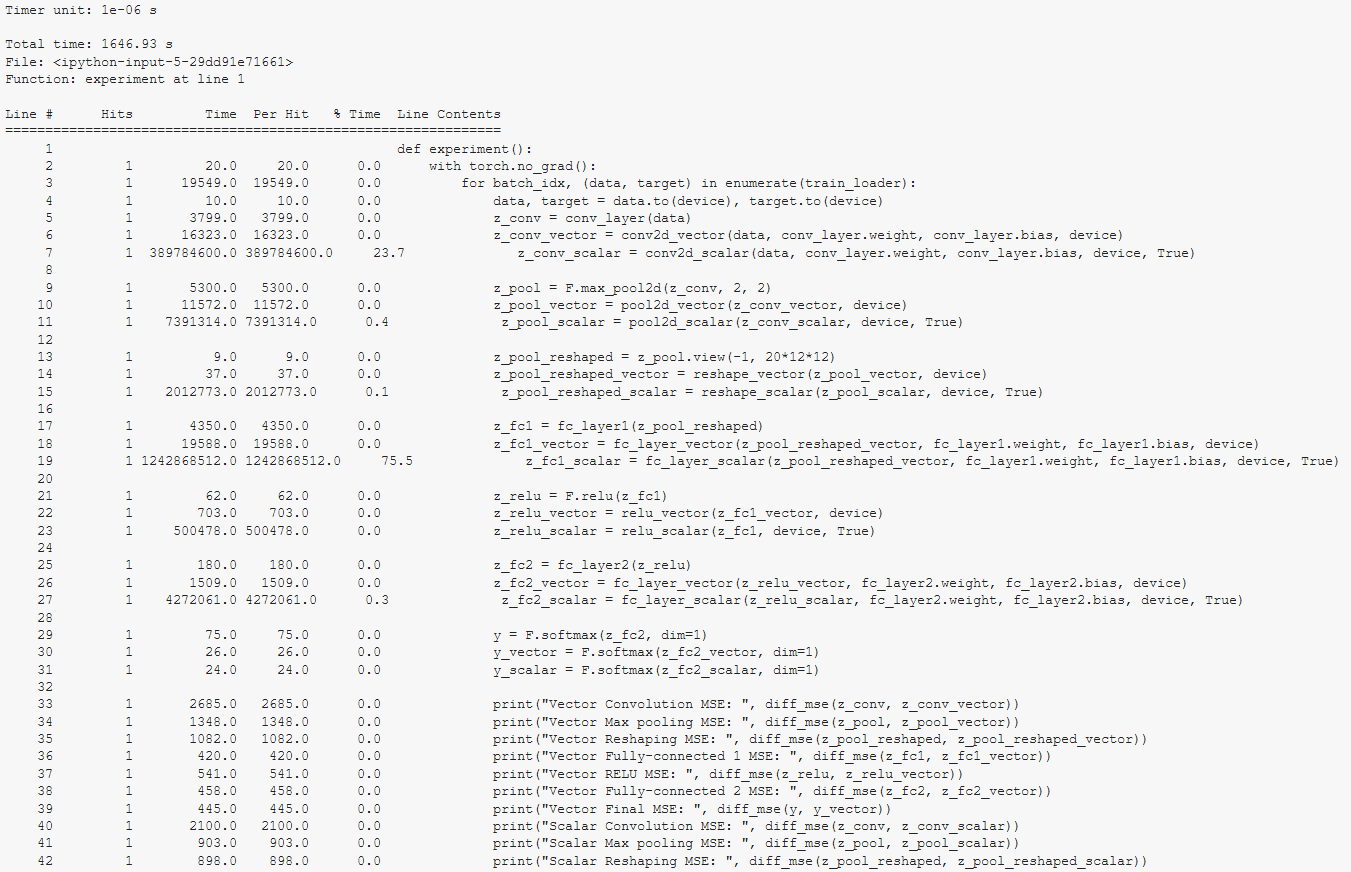

In [8]:
from IPython.display import Image
Image(r'img/lprun.PNG')